<a href="https://colab.research.google.com/github/giovannasantoloni/Projetos-de-Sistemas-Inteligentes-de-Apoio-Decis-o/blob/main/Projeto_Final_Curso_BI_Master_2021_1_Giovanna_Dohnert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final Curso BI Master 2021-1
> Por Giovanna Santoloni Dohnert

In [1]:
#Montagem do Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importar Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from google.colab import drive
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
#Importar Aplicações
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from scipy import ndimage, misc
import skimage
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models.cloning import training
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Reshape
from google.colab import drive
from shutil import copyfile

In [4]:
#Caminho da Base de Dados
import os
workdir_path = '/content/drive/My Drive/Projeto Final BI/Dataset' 
os.chdir(workdir_path)

In [5]:
# Caminho do dataset
full_dataset = r'/content/drive/My Drive/Projeto Final BI/Dataset'

In [6]:
!ls

 Abyssinian   Birman  'British Short Hair'  'Maine Coon'   Ragdoll
 Bengal       Bombay  'Egyptian Mau'	     Persian	   Siamese


In [7]:
#Definição de Parâmetros

#Número de Classes 
n_classes = 10

#Tamanho das Imagens
target_size = (224, 224)

#Tamanho do Lote para Treinamento
batch_size = 32


In [8]:
# Olhando o número de arquivos por classe
for nome_pasta in os.listdir(full_dataset):
    caminho_pasta = os.path.join(full_dataset, nome_pasta)
  
    if os.path.isdir(caminho_pasta):
        
        lista_arquivos = os.listdir(caminho_pasta)  

        num_arquivos = len(lista_arquivos)     

        print("Pasta:", nome_pasta, " - Número de arquivos:", num_arquivos)

Pasta: Abyssinian  - Número de arquivos: 187
Pasta: Bengal  - Número de arquivos: 191
Pasta: Birman  - Número de arquivos: 186
Pasta: Bombay  - Número de arquivos: 179
Pasta: British Short Hair  - Número de arquivos: 165
Pasta: Egyptian Mau  - Número de arquivos: 176
Pasta: Maine Coon  - Número de arquivos: 158
Pasta: Persian  - Número de arquivos: 163
Pasta: Ragdoll  - Número de arquivos: 177
Pasta: Siamese  - Número de arquivos: 173


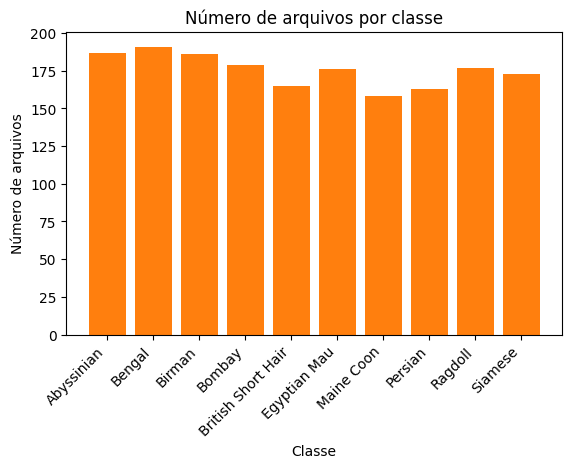

In [9]:
# Criando as listas para armazenar os dados
classes = []
num_arquivos = []

# Olhando o número de arquivos por classe
for nome_pasta in os.listdir(full_dataset):
    caminho_pasta = os.path.join(full_dataset, nome_pasta)
  
    if os.path.isdir(caminho_pasta):
        
        lista_arquivos = os.listdir(caminho_pasta)  

        num_arq = len(lista_arquivos)
        
        classes.append(nome_pasta)
        num_arquivos.append(num_arq)

# Gerando o gráfico de barras
plt.bar(classes, num_arquivos)
plt.title("Número de arquivos por classe")
plt.xlabel("Classe")
plt.ylabel("Número de arquivos")
plt.subplots_adjust(bottom=0.25)
plt.bar(classes, num_arquivos, width=0.8)
plt.xticks(rotation=45, ha="right")
plt.show()

In [10]:
# Criando o gerador de imagens com as transformações desejadas
image_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    # rotation_range=20, 
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # brightness_range=[0.5, 1.5],
    # shear_range=0.2,
    # fill_mode='reflect',
    # channel_shift_range=50.0,
    # vertical_flip=True,
)

In [11]:
# Criando o dataset de Treino
train_dataset = image_generator.flow_from_directory(batch_size=batch_size, 
                                                    directory=full_dataset ,
                                                    shuffle=True,
                                                    # target_size=target_size,
                                                    subset="training",
                                                    class_mode='categorical')

# Criando o dataset de Validação
validation_dataset = image_generator.flow_from_directory(batch_size=batch_size, 
                                                         directory=full_dataset,
                                                        #  shuffle=True,
                                                         target_size=target_size,
                                                         subset="validation",
                                                         class_mode='categorical')

# Criando o conjunto de Teste com mesmo tamanho do conjunto de Validação
test_dataset = image_generator.flow_from_directory(batch_size=batch_size, 
                                                    directory=full_dataset,
                                                    # shuffle = True,
                                                    target_size =target_size,
                                                    class_mode = 'categorical',
                                                    subset = 'validation')

Found 1406 images belonging to 10 classes.
Found 346 images belonging to 10 classes.
Found 346 images belonging to 10 classes.


In [12]:
# Importar a arquitetura ResNet50V2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

# carregar a arquitetura ResNet50V2 pré-treinada
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(*target_size, 3))

94668760/94668760 [==============================] - 3s 0us/step


In [13]:
# congelar as camadas da base
for layer in base_model.layers:
    layer.trainable = False

In [14]:
# adicionar camadas adicionais ao modelo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) 

# Adicionamos uma camada de dropout de 0,5, o que significa que metade dos neurônios da camada anterior serão aleatoriamente desativados
# durante o treinamento, para evitar overfitting.

x = Dropout(0.5)(x)  

predictions = Dense(n_classes, activation='softmax')(x)

In [15]:
# criar modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
# Learning Rate Fixo
lr_fixed = 1e-4

# Beta 1
beta_1 = 0.9

# compilar o modelo com a learning_rate fixa
model.compile(optimizer=Adam(learning_rate=lr_fixed, beta_1=beta_1), loss='categorical_crossentropy', metrics=['acc'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [18]:
#checkpoints
model_path = '/content/drive/My Drive/Projeto Final BI/Best Model'
mc = ModelCheckpoint(filepath=model_path, save_best_only=True)

In [19]:
# Treinar o Modelo
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[mc])

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 2.1268 - acc: 0.2838 

44/44 [==============================] - 748s 17s/step - loss: 2.1268 - acc: 0.2838 - val_loss: 1.0758 - val_acc: 0.6965
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 1.2140 - acc: 0.5839

44/44 [==============================] - 33s 765ms/step - loss: 1.2140 - acc: 0.5839 - val_loss: 0.6610 - val_acc: 0.8266
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 0.8758 - acc: 0.7169

44/44 [==============================] - 32s 734ms/step - loss: 0.8758 - acc: 0.7169 - val_loss: 0.4918 - val_acc: 0.8757
Epoch 4/50
44/44 [==============================] - ETA: 0s - loss: 0.6761 - acc: 0.7902

44/44 [==============================] - 37s 842ms/step - loss: 0.6761 - acc: 0.7902 - val_loss: 0.4036 - val_acc: 0.8931
Epoch 5/50
44/44 [==============================] - ETA: 0s - loss: 0.5615 - acc: 0.8321

44/44 [==============================] - 32s 728ms/step - loss: 0.5615 - acc: 0.8321 - val_loss: 0.3722 - val_acc: 0.8815
Epoch 6/50
44/44 [==============================] - ETA: 0s - loss: 0.4864 - acc: 0.8414

44/44 [==============================] - 32s 744ms/step - loss: 0.4864 - acc: 0.8414 - val_loss: 0.3561 - val_acc: 0.8844
Epoch 7/50
44/44 [==============================] - ETA: 0s - loss: 0.4398 - acc: 0.8649

44/44 [==============================] - 35s 799ms/step - loss: 0.4398 - acc: 0.8649 - val_loss: 0.3139 - val_acc: 0.8844
Epoch 8/50
44/44 [==============================] - ETA: 0s - loss: 0.3736 - acc: 0.8791

44/44 [==============================] - 32s 745ms/step - loss: 0.3736 - acc: 0.8791 - val_loss: 0.2989 - val_acc: 0.8988
Epoch 9/50
44/44 [==============================] - ETA: 0s - loss: 0.3610 - acc: 0.8898

44/44 [==============================] - 35s 800ms/step - loss: 0.3610 - acc: 0.8898 - val_loss: 0.2819 - val_acc: 0.9046
Epoch 10/50
44/44 [==============================] - 14s 324ms/step - loss: 0.3311 - acc: 0.8883 - val_loss: 0.2954 - val_acc: 0.8931
Epoch 11/50
44/44 [==============================] - 14s 313ms/step - loss: 0.2992 - acc: 0.9075 - val_loss: 0.2907 - val_acc: 0.8873
Epoch 12/50
44/44 [==============================] - ETA: 0s - loss: 0.2842 - acc: 0.9125

44/44 [==============================] - 33s 754ms/step - loss: 0.2842 - acc: 0.9125 - val_loss: 0.2729 - val_acc: 0.9046
Epoch 13/50
44/44 [==============================] - 14s 321ms/step - loss: 0.2618 - acc: 0.9317 - val_loss: 0.2830 - val_acc: 0.8960
Epoch 14/50
44/44 [==============================] - ETA: 0s - loss: 0.2411 - acc: 0.9296

44/44 [==============================] - 34s 787ms/step - loss: 0.2411 - acc: 0.9296 - val_loss: 0.2725 - val_acc: 0.9104
Epoch 15/50
44/44 [==============================] - ETA: 0s - loss: 0.2205 - acc: 0.9346

44/44 [==============================] - 33s 749ms/step - loss: 0.2205 - acc: 0.9346 - val_loss: 0.2678 - val_acc: 0.9075
Epoch 16/50
44/44 [==============================] - ETA: 0s - loss: 0.2239 - acc: 0.9317

44/44 [==============================] - 33s 764ms/step - loss: 0.2239 - acc: 0.9317 - val_loss: 0.2669 - val_acc: 0.9046
Epoch 17/50
44/44 [==============================] - ETA: 0s - loss: 0.2072 - acc: 0.9424

44/44 [==============================] - 33s 766ms/step - loss: 0.2072 - acc: 0.9424 - val_loss: 0.2624 - val_acc: 0.9162
Epoch 18/50
44/44 [==============================] - 16s 367ms/step - loss: 0.1968 - acc: 0.9474 - val_loss: 0.2718 - val_acc: 0.9017
Epoch 19/50
44/44 [==============================] - 14s 311ms/step - loss: 0.1811 - acc: 0.9502 - val_loss: 0.2635 - val_acc: 0.9075
Epoch 20/50
44/44 [==============================] - ETA: 0s - loss: 0.1812 - acc: 0.9417

44/44 [==============================] - 33s 751ms/step - loss: 0.1812 - acc: 0.9417 - val_loss: 0.2531 - val_acc: 0.9191
Epoch 21/50
44/44 [==============================] - 14s 315ms/step - loss: 0.1706 - acc: 0.9509 - val_loss: 0.2620 - val_acc: 0.9191
Epoch 22/50
44/44 [==============================] - 14s 309ms/step - loss: 0.1488 - acc: 0.9666 - val_loss: 0.2629 - val_acc: 0.9075
Epoch 23/50
44/44 [==============================] - ETA: 0s - loss: 0.1451 - acc: 0.9630

44/44 [==============================] - 32s 746ms/step - loss: 0.1451 - acc: 0.9630 - val_loss: 0.2456 - val_acc: 0.9220
Epoch 24/50
44/44 [==============================] - 14s 310ms/step - loss: 0.1389 - acc: 0.9644 - val_loss: 0.2620 - val_acc: 0.8988
Epoch 25/50
44/44 [==============================] - 14s 307ms/step - loss: 0.1340 - acc: 0.9651 - val_loss: 0.2577 - val_acc: 0.9162
Epoch 26/50
44/44 [==============================] - 14s 322ms/step - loss: 0.1293 - acc: 0.9637 - val_loss: 0.2642 - val_acc: 0.9075
Epoch 27/50
44/44 [==============================] - ETA: 0s - loss: 0.1168 - acc: 0.9687

44/44 [==============================] - 35s 804ms/step - loss: 0.1168 - acc: 0.9687 - val_loss: 0.2426 - val_acc: 0.9162
Epoch 28/50
44/44 [==============================] - 14s 315ms/step - loss: 0.1118 - acc: 0.9716 - val_loss: 0.2588 - val_acc: 0.9162
Epoch 29/50
44/44 [==============================] - 13s 303ms/step - loss: 0.1103 - acc: 0.9758 - val_loss: 0.2591 - val_acc: 0.9104
Epoch 30/50
44/44 [==============================] - 14s 312ms/step - loss: 0.1099 - acc: 0.9708 - val_loss: 0.2569 - val_acc: 0.9191
Epoch 31/50
44/44 [==============================] - 13s 305ms/step - loss: 0.1023 - acc: 0.9730 - val_loss: 0.2570 - val_acc: 0.9191
Epoch 32/50
44/44 [==============================] - 14s 308ms/step - loss: 0.0896 - acc: 0.9822 - val_loss: 0.2460 - val_acc: 0.9249
Epoch 33/50
44/44 [==============================] - 14s 307ms/step - loss: 0.0934 - acc: 0.9772 - val_loss: 0.2540 - val_acc: 0.9162
Epoch 34/50
44/44 [==============================] - 14s 312ms/step - loss

In [20]:
# carregar melhor modelo
model.load_weights(model_path)

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

11/11 [==============================] - 3s 245ms/step - loss: 0.2426 - acc: 0.9162
Test Loss: 0.2426
Test Accuracy: 0.9162


In [22]:
# Get the class labels in the correct order

# Initialize empty lists to store predictions and true labels
predictions = []
batch_labels = []

# Iterate over generator batches and collect predictions
for _ in range(len(test_dataset)):
    batch_images, batch_labels_batch = test_dataset.next()
    batch_predictions = model.predict_on_batch(batch_images)
    predictions.extend(batch_predictions)
    batch_labels.extend(batch_labels_batch)

# Convert the predicted probabilities to class labels
predictions = np.array(predictions)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(batch_labels, axis=1)

In [23]:
# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9159


In [24]:
# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy Score: {acc:.4f}")

Accuracy Score: 0.9162


In [25]:
conf_matrix = confusion_matrix(y_true, y_pred)

In [26]:
# Retrieve possible classes
classes = test_dataset.class_indices
# Get class labels
classes = list(classes.keys())

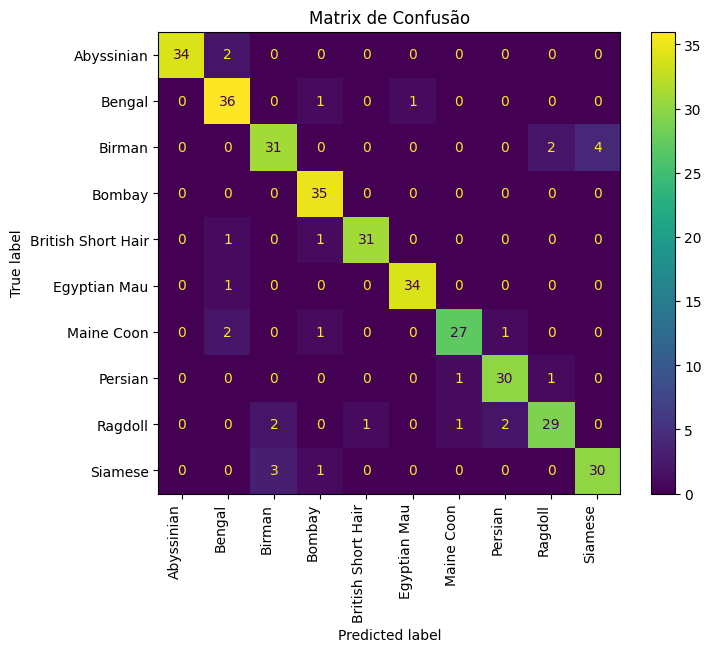

In [27]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.set(title='Matrix de Confusão')
display = ConfusionMatrixDisplay(conf_matrix, display_labels=classes)
display.plot(ax=ax);

# Rotate x-axis tick labels by 90 degrees
ax.set_xticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=90, ha='right')

plt.show()

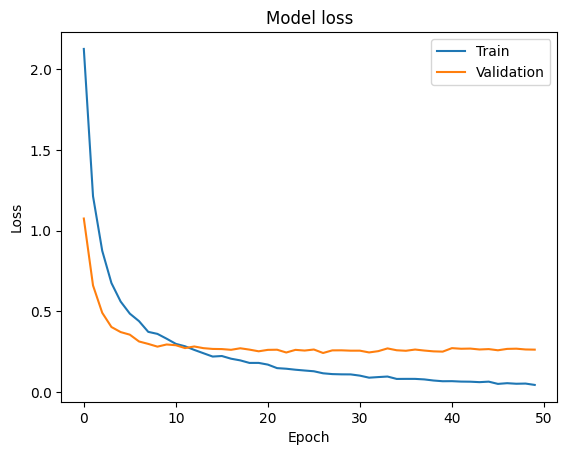

In [28]:
# Plotar o gráfico de loss durante o treinamento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

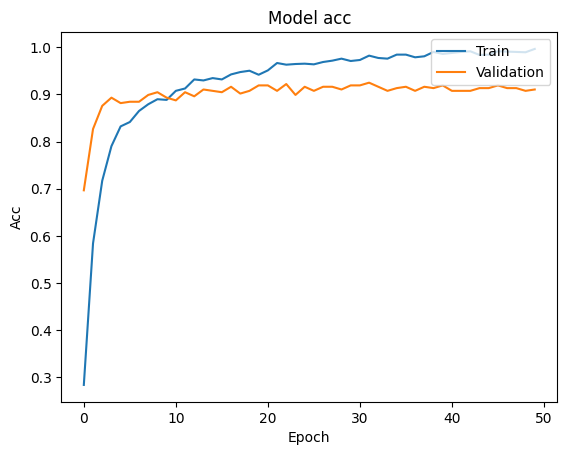

In [29]:
# Plotar o gráfico de acc durante o treinamento
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()